In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel
from e6dataflow.tools.fittools import e6_fit

In [2]:
run_name = 'run0'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name, datamodel_name='datamodel_small')

Loading datamodel from C:\Users\Emma\Downloads\analysis\analysis\2020\12\28\run0\run0-datamodel_small.p


In [4]:
datamodel.save_datamodel(datamodel_path=Path('C:\\Users\\Emma\\Downloads\\analysis\\analysis\\2020\\12\\28\\run0\\test'))

Saving datamodel to C:\Users\Emma\Downloads\analysis\analysis\2020\12\28\run0\test\run0-datamodel.p


In [6]:
cav_odt_int_list = [1,2,3,4,5,6]
pzt_para_list = [5]
num_points = datamodel.num_points #len(pzt_para_list) * len(cav_odt_int_list)

tweezer_freq_list = [107,108,109,110,111,112,113,114,115,116]
num_tweezers = 10 #len(tweezer_freq_list)

mol_freq_list = [4, 4, 4.5, 5, 5.5, 6, 6.25, 6.5, 6.75, 7, 7.2, 7.4, 7.6, 7.8, 8]
num_frames = 17 #len(mol_freq_list) + 2

num_shots = datamodel.num_shots

print(num_points,'points')
print(num_frames,'frames')
print(num_shots,'shots')

t_exposure = 500

6 points
17 frames
0 shots


In [ ]:
survival_probability_array = np.zeros([num_points, num_frames, num_tweezers])
for point_num in range(num_points):
    for frame_num in range(num_frames):
        frame_key = f'frame-{frame_num:02d}'
        for tweezer_num in range(num_tweezers):
            tweezer_key = f'tweezer-{tweezer_num:02d}'
            datafield_name = f'{frame_key}_{tweezer_key}_counts'
            verified_list = datamodel.get_data_by_point(datafield_name, point_num)
            num_above = np.sum(np.array(verified_list))
            num_total = len(verified_list)
            frac_above = num_above / num_total
            survival_probability_array[point_num, frame_num, tweezer_num] = frac_above

In [ ]:
counts_array_all = np.empty([num_shots, num_frames, num_tweezers])
for shot_num in range(num_shots): 
    for frame_num in range(num_frames):
        tweezer_num = 0
        for tweezer_freq in tweezer_freq_list: 
#             counts_array_all[shot_num,frame_num,tweezer_num] = \
#                 datamodel.data_dict['shot_data'][f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}_counts'][f'shot_{shot_num:05d}']
            counts_array_all[shot_num,frame_num,tweezer_num] = \
                datamodel.get_data(f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}_counts',shot_num)
            # two diff ways to get counts for each shot. get_data method seems better. 
            tweezer_num += 1

Below, another way to get counts, without needing to write a loop for every shot. 

In [ ]:
counts_array_all_2 = np.empty([num_shots, num_frames, num_tweezers])
for frame_num in range(num_frames):
    tweezer_num=0
    for tweezer_freq in tweezer_freq_list:
        counts_array_all_2[:,frame_num,tweezer_num]=\
            datamodel.get_data(f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}_counts','all')
        tweezer_num+=1

Is there a way to do get_data and pull many shots at once? 

$\rightarrow$ get_data_by_point does this (but by point, as indicated by the name)

Implemented get_data method (changed Justin's get_data to get_datum) 

What do we want to do with the data??? 
 - Look at the counts for each point, frame, and tweezer? 
 - Check the ROIs? 
 
 ^ or are those things we want the reporters to generate? 
 
 Get_data:
 - get a certain set of shots (and return an array?) 

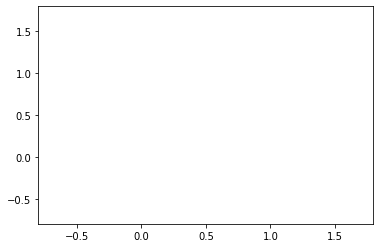

In [7]:
plt.figure('test')
for frame_num in range(1):
    for tweezer_num in range(num_tweezers):
        plt.plot(datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{tweezer_num:02d}_counts',0),'.')
# plt.plot(counts_array_all[:,0,1],'.')
# plt.plot(counts_array_all[:,0,2],'.')

In [ ]:
datamodel.datamodel_file_path

In [ ]:
datamodel.last_handled_shot

In [ ]:
Path(Path.cwd(), 'test.p')

In [ ]:
datamodel.run()

In [ ]:
len(datamodel.get_data_by_point('frame-00_tweezer-02_counts',1))

In [ ]:
Path.cwd()

In [ ]:
frames_array = np.zeros([len(cav_odt_int_list), len(pzt_para_list), num_frames, 350,50])
for shot_num in range(num_shots):
    if quiet == False: 
        print(f'shot_num={shot_num}')
    file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
    hf = h5py.File(data_path/file_name, 'r')
    point = shot_num % num_points
    cav_odt_int_counter = point // len(pzt_para_list)
    cav_odt_int = cav_odt_int_list[cav_odt_int_counter]
    pzt_para_counter = point % len(pzt_para_list)
    pzt_para = pzt_para_list[pzt_para_counter]
    for frame_num in range(num_frames):
        photo = np.array(hf.get('frame-'+str(frame_num).zfill(2)))
        frames_array[cav_odt_int_counter, pzt_para_counter, frame_num] += photo
        
        if quiet == False: 
            if frame_num == 5:
                vmin = 105
                vmax = 140

                fig,ax = plt.subplots(1, 1,figsize=(10, 10) )
                ax.imshow(photo, norm = colors.Normalize(vmin=vmin,vmax=vmax), cmap='hot', interpolation='nearest')
                for tweezer_freq in tweezer_freq_list:
                    rect1 = patches.Rectangle((round(roi_center(tweezer_freq, 0,  pzt_para)[0] - roi_width/2),round(roi_center(tweezer_freq, 0,  pzt_para)[1] - roi_height/2)), roi_width,roi_height,linewidth=1,edgecolor='white',facecolor='none')
                    ax.add_patch(rect1)
                plt.show()
                print(counts_array_all[shot_num, frame_num])
            
    hf.close
frames_array= frames_array/num_shots*num_points